In [161]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
np.random.seed(42)

In [162]:
def func_1(x):
    return np.sin(2*x)

In [163]:
def func_2(x):
    if func_1(x) >= 0:
        return 1
    else:
        return -1

In [164]:
def phi(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

In [165]:
def phi_matrix(x, mu, sigma):
    phi_matrix = np.zeros((len(x), len(mu)))
    for i in range(len(x)):
        for j in range(len(mu)):
            phi_matrix[i, j] = phi(x[i], mu[j], sigma)
    return phi_matrix

In [166]:
def predict(x, w, mu, sigma):
    phi_mat = phi_matrix(x, mu, sigma)
    return phi_mat @ w

In [167]:
def predict_square(x, w, mu, sigma):
    phi_mat = phi_matrix(x, mu, sigma)

    return np.sign(phi_mat @ w)

In [168]:
def batch_learning(x, y, mu, sigma):
    phi_mat = phi_matrix(x, mu, sigma)
    w = np.linalg.inv(phi_mat.T @ phi_mat) @ phi_mat.T @ y
    return w

In [169]:
def calc_error(pred, y):
    # Remove any NaN values before calculating errors
    mask = ~np.isnan(pred) & ~np.isnan(y)
    if not np.any(mask):
        return np.inf, np.inf
    return mse(pred[mask], y[mask]), mae(pred[mask], y[mask])

In [170]:
def sequential_learning(x_train, y_train, mu, sigma, epochs=1000, lr=0.01):
    w = np.zeros(len(mu))
    errors = []
    
    for epoch in range(epochs):
        # Shuffle the data
        indices = np.random.permutation(len(x_train))
        x_shuffled = x_train[indices]
        y_shuffled = y_train[indices]
        
        epoch_error = 0
        for i in range(len(x_train)):
            # Get phi vector for current input
            phi_vec = np.array([phi(x_shuffled[i], m, sigma) for m in mu])
            
            # Calculate prediction and error
            pred = w @ phi_vec
            error = y_shuffled[i] - pred
            
            # Update weights
            w += lr * error * phi_vec
            
            epoch_error += error**2
            
        # Store mean squared error for this epoch
        errors.append(epoch_error / len(x_train))
    
    return w, errors

In [171]:
def find_min_units_for_error(x_train, y_train, x_test, y_test, error_thres, sigma=1, ftype='sin2x'):
    results = {}
    for thres in error_thres:
        n_units = 2
        while True:
            mu = np.linspace(min(x_train), max(x_train), n_units)

            w = batch_learning(x_train, y_train, mu, sigma)

            if ftype == 'sin2x':
                train_pred = predict(x_train, w, mu, sigma)
                test_pred = predict(x_test, w, mu, sigma)
            elif ftype == 'square2x':
                train_pred = predict_square(x_train, w, mu, sigma)
                test_pred = predict_square(x_test, w, mu, sigma)

            train_error, _ = calc_error(train_pred, y_train)
            test_error, _ = calc_error(test_pred, y_test)

            if test_error < thres:
                results[thres] = {
                    'number units': n_units,
                    'train error': train_error,
                    'test error': test_error
                }
                break

            n_units += 1

            if n_units > 50:
                results[thres] = {
                    'number units': 'None',
                    'train error': train_error,
                    'test error': test_error
                }
                break

    return results  

In [172]:
def plot_approximation(x_train, y_train, x_test, y_test, mu, sigma, w, title, ftype='sin2x'):
    plt.figure(figsize=(10, 6))
    plt.plot(x_train, y_train, 'b.', label='Training data')
    plt.plot(x_test, y_test, 'g.', label='Test data')
    
    # Generate smooth curve for predictions
    x_smooth = np.linspace(min(x_train), max(x_train), 200)
    if ftype == 'sin2x':
        y_pred = predict(x_smooth, w, mu, sigma)
    elif ftype == 'square2x':
        y_pred = predict_square(x_smooth, w, mu, sigma)
    plt.plot(x_smooth, y_pred, 'r-', label='RBF prediction')
    
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [173]:
def plot_width_analysis(width_results):
    """Plot comparative analysis of different RBF widths"""
    # Create figure with two subplots (MSE and MAE)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Get sigma values and sort them
    sigmas = sorted(width_results.keys())
    
    # Extract values for plotting
    batch_mse = [width_results[s]['batch']['mse'] for s in sigmas]
    seq_mse = [width_results[s]['sequential']['mse'] for s in sigmas]
    batch_mae = [width_results[s]['batch']['mae'] for s in sigmas]
    seq_mae = [width_results[s]['sequential']['mae'] for s in sigmas]
    
    # Plot MSE
    ax1.plot(sigmas, batch_mse, 'bo-', label='Batch Learning')
    ax1.plot(sigmas, seq_mse, 'ro-', label='Sequential Learning')
    ax1.set_xlabel('RBF Width')
    ax1.set_ylabel('MSE')
    ax1.set_title('MSE vs RBF Width')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    # Plot MAE
    ax2.plot(sigmas, batch_mae, 'bo-', label='Batch Learning')
    ax2.plot(sigmas, seq_mae, 'ro-', label='Sequential Learning')
    ax2.set_xlabel('RBF Width')
    ax2.set_ylabel('MAE')
    ax2.set_title('MAE vs RBF Width')
    ax2.legend()
    ax2.grid(True)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

In [174]:
def plot_learning_error(errors_dict, title, ylabel):
    plt.figure(figsize=(12, 6))
    
    for lr, error in errors_dict.items():
        plt.plot(error, label=f'Learning rate = {lr}')
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    # plt.yscale('log')  # Add log scale to better see the differences
    plt.show()

In [175]:
def plot_errors(errors_dict, title, ylabel):
    plt.figure(figsize=(12, 6))

    # Plot errors for each error type (MSE and MAE)
    for error_type, error in errors_dict.items():
        plt.plot(error, label=error_type)
    
    plt.title(title)
    plt.xlabel('Number of RBF units')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [176]:
def analyze_rbf_width_effect(x_train, y_train, x_test, y_test, n_units, sigma_values):
    """Analyze effect of RBF width on approximation quality"""
    width_results = {}
    
    for sigma in sigma_values:
        mu = np.linspace(min(x_train), max(x_train), n_units)
        
        # Train both batch and sequential
        w_batch = batch_learning(x_train, y_train, mu, sigma)
        w_seq, _ = sequential_learning(x_train, y_train, mu, sigma)
        
        # Get predictions
        test_pred_batch = predict(x_test, w_batch, mu, sigma)
        test_pred_seq = predict(x_test, w_seq, mu, sigma)
        
        # Calculate errors
        batch_mse, batch_mae = calc_error(test_pred_batch, y_test)
        seq_mse, seq_mae = calc_error(test_pred_seq, y_test)
        
        width_results[sigma] = {
            'batch': {'mse': batch_mse, 'mae': batch_mae},
            'sequential': {'mse': seq_mse, 'mae': seq_mae}
        }
        
        # Plot approximations for visual comparison
        plot_approximation(x_train, y_train, x_test, y_test, 
                         mu, sigma, w_batch, f'Batch Learning (σ={sigma})')
        plot_approximation(x_train, y_train, x_test, y_test, 
                         mu, sigma, w_seq, f'Sequential Learning (σ={sigma})')

    return width_results

In [177]:
def analyze_node_positioning(x_train, y_train, x_test, y_test, n_units, sigma):
    """Compare different RBF node positioning strategies"""
    # Linear spacing (current method)
    mu_linear = np.linspace(min(x_train), max(x_train), n_units)
    
    # Random positioning
    mu_random = np.random.uniform(min(x_train), max(x_train), n_units)

    positions = {
        'linear': mu_linear,
        'random': mu_random,
    }
    
    results = {}
    for pos_type, mu in positions.items():
        w = batch_learning(x_train, y_train, mu, sigma)
        test_pred = predict(x_test, w, mu, sigma)
        mse_error, mae_error = calc_error(test_pred, y_test)
        
        results[pos_type] = {
            'mse': mse_error,
            'mae': mae_error
        }
        
        plot_approximation(x_train, y_train, x_test, y_test, 
                         mu, sigma, w, f'Node Positioning: {pos_type}')
    
    return results

In [178]:
pattern = np.arange(0, 2*np.pi, 0.1)
N = len(pattern)

In [179]:
target1 = np.array([func_1(x) for x in pattern])
target2 = np.array([func_2(x) for x in pattern])

In [180]:
pattern_test = np.arange(0.05, 2*np.pi, 0.1)
N_test = len(pattern_test)
target1_test = np.array([func_1(x) for x in pattern_test])
target2_test = np.array([func_2(x) for x in pattern_test])

In [181]:
# Add noise to training and test data
target1_noise = target1 + np.random.normal(0, 0.1, N)
target2_noise = target2 + np.random.normal(0, 0.1, N)

target1_test_noise = target1_test + np.random.normal(0, 0.1, N_test)
target2_test_noise = target2_test + np.random.normal(0, 0.1, N_test)

In [182]:
def compare_on_clean_data(model_params, sigma_values, noisy_trained=True):
    """Compare performance on clean test data for models trained on noisy/clean data"""
    if noisy_trained:
        train_data = target1_noise
        test_data = target1  # Clean test data
    else:
        train_data = target1
        test_data = target1
    
    results = {}
    for sigma in sigma_values:
        mu = np.linspace(min(pattern), max(pattern), model_params['n_units'])
        
        # Train models
        w_batch = batch_learning(pattern, train_data, mu, sigma)
        w_seq, _ = sequential_learning(pattern, train_data, mu, sigma, 
                                     epochs=model_params['epochs'], 
                                     lr=model_params['lr'])
        
        # Test on clean data
        pred_batch = predict(pattern_test, w_batch, mu, sigma)
        pred_seq = predict(pattern_test, w_seq, mu, sigma)
        
        # Calculate errors
        mse_batch, mae_batch = calc_error(pred_batch, test_data)
        mse_seq, mae_seq = calc_error(pred_seq, test_data)
        
        results[sigma] = {
            'batch': {'mse': mse_batch, 'mae': mae_batch},
            'sequential': {'mse': mse_seq, 'mae': mae_seq}
        }
    
    return results

In [183]:
error_thres = [0.1, 0.01, 0.001]
results_sin = find_min_units_for_error(
    pattern, 
    target1, 
    pattern_test, 
    target1_test, 
    error_thres,
    ftype='sin2x')

In [184]:
results_square = find_min_units_for_error(
    pattern, 
    target2, 
    pattern_test, 
    target2_test, 
    error_thres,
    ftype='square2x')

Sin function with error threshold 0.1:
Number of units: 6
Training error: 0.006911832896931795
Test error: 0.007383879026677276



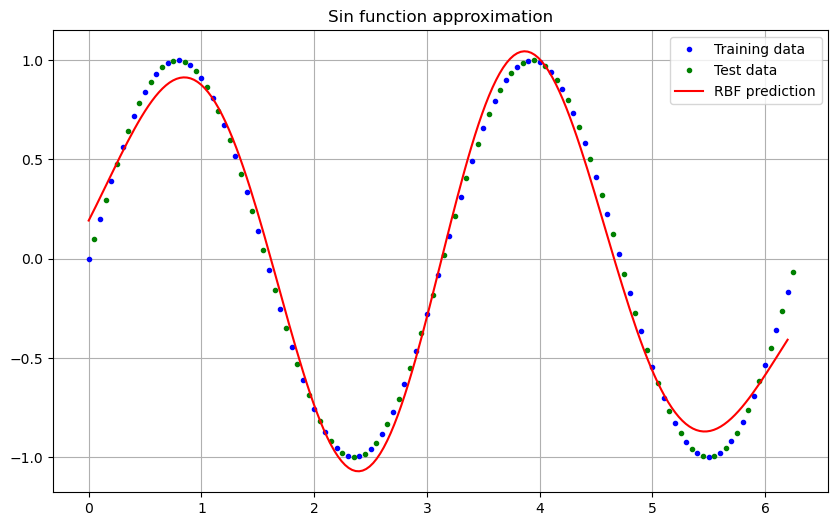

Sin function with error threshold 0.01:
Number of units: 6
Training error: 0.006911832896931795
Test error: 0.007383879026677276



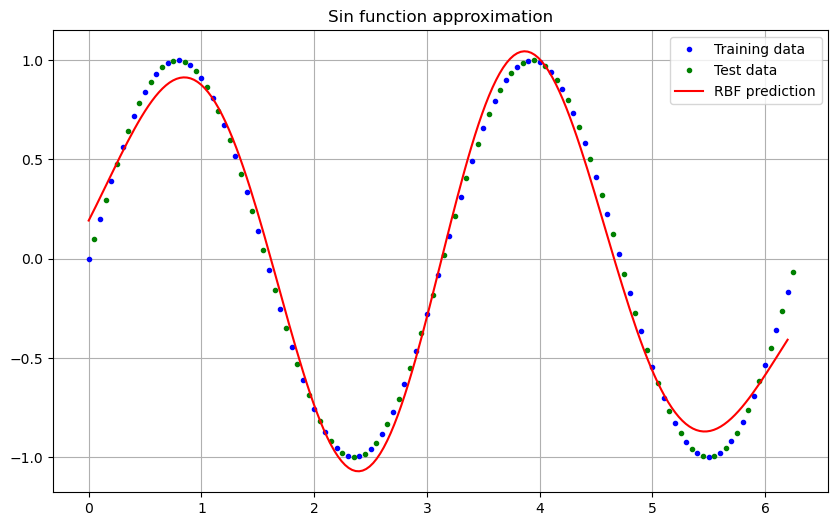

Sin function with error threshold 0.001:
Number of units: 8
Training error: 0.00014883853246689036
Test error: 0.0001718219236306498



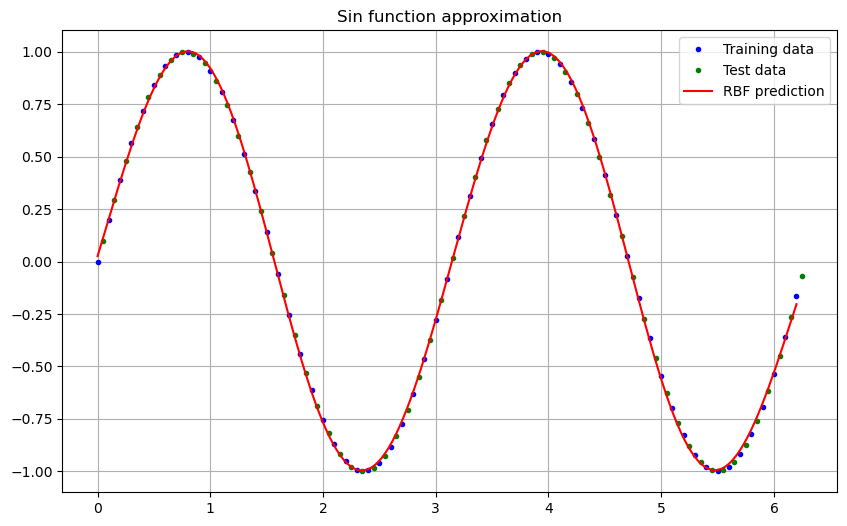

In [185]:
for thres, result in results_sin.items():
    print(f'Sin function with error threshold {thres}:')
    print(f'Number of units: {result["number units"]}')
    print(f'Training error: {result["train error"]}')
    print(f'Test error: {result["test error"]}')
    print()
    n_units = result['number units']
    if n_units != 'None':
        mu = np.linspace(min(pattern), max(pattern), n_units)
        w = batch_learning(pattern, target1, mu, 1)
        plot_approximation(pattern, target1, pattern_test, target1_test, mu, 1, w, 'Sin function approximation', ftype='sin2x')

Square function with error threshold 0.1:
Number of units: 6
Training error: 0.0
Test error: 0.0



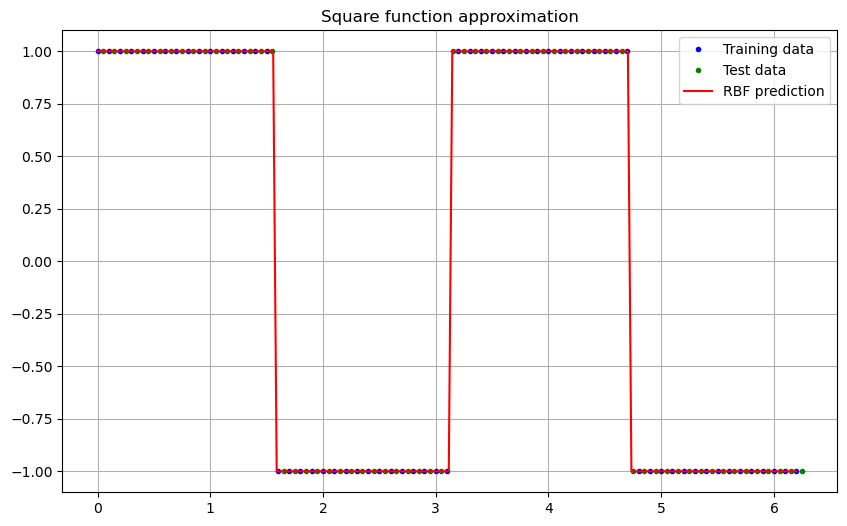

Square function with error threshold 0.01:
Number of units: 6
Training error: 0.0
Test error: 0.0



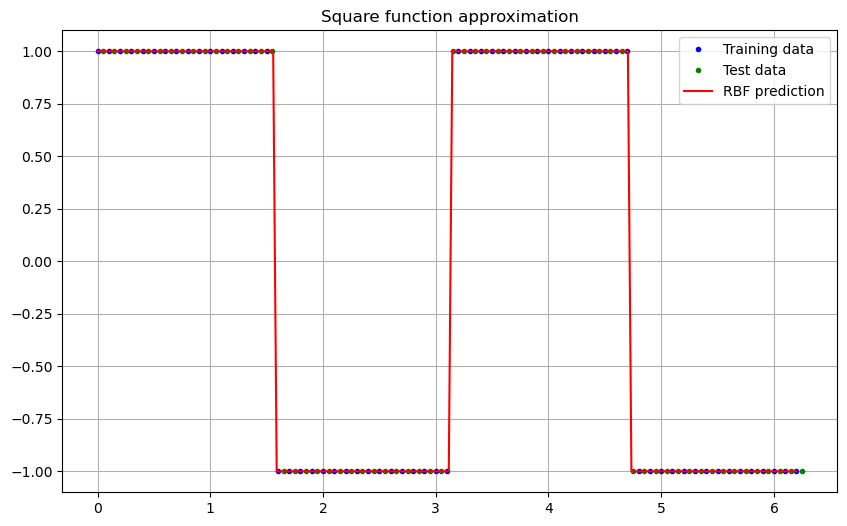

Square function with error threshold 0.001:
Number of units: 6
Training error: 0.0
Test error: 0.0



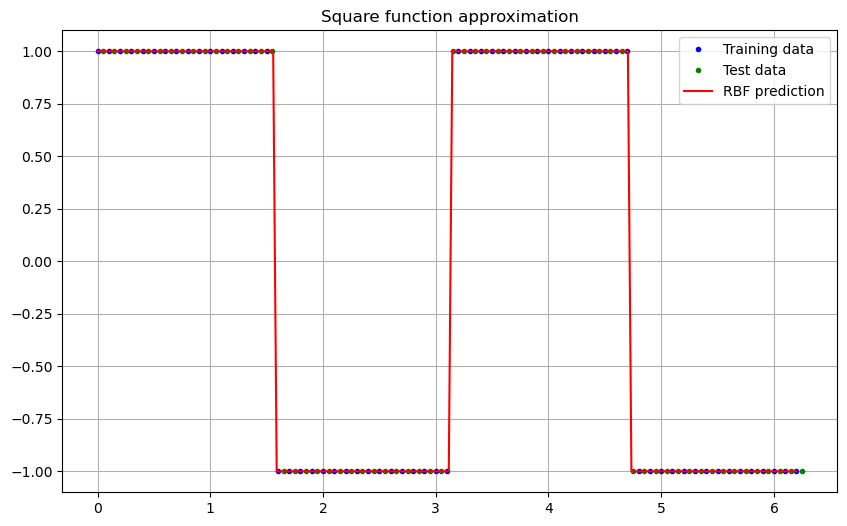

In [186]:
for thres, result in results_square.items():
    print(f'Square function with error threshold {thres}:')
    print(f'Number of units: {result["number units"]}')
    print(f'Training error: {result["train error"]}')
    print(f'Test error: {result["test error"]}')
    print()
    n_units = result['number units']
    if n_units != 'None':
        mu = np.linspace(min(pattern), max(pattern), n_units)
        w = batch_learning(pattern, target2, mu, 1)
        plot_approximation(pattern, target2, pattern_test, target2_test, mu, 1, w, 'Square function approximation', ftype='square2x')

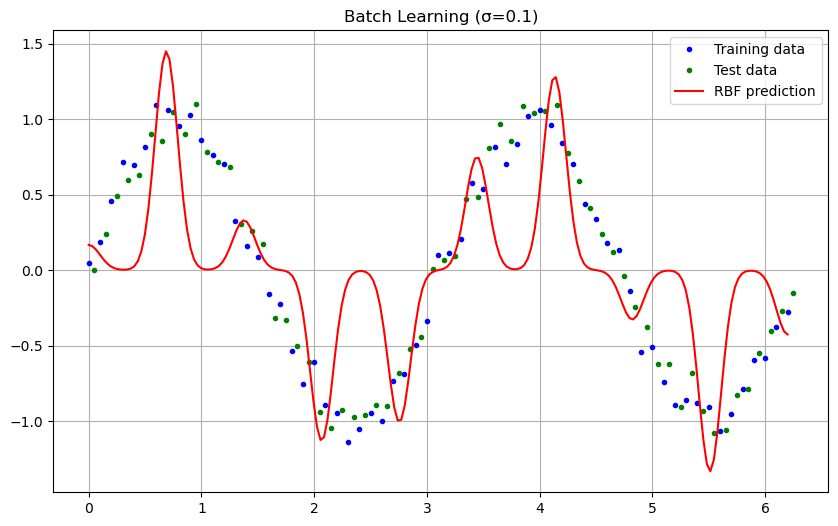

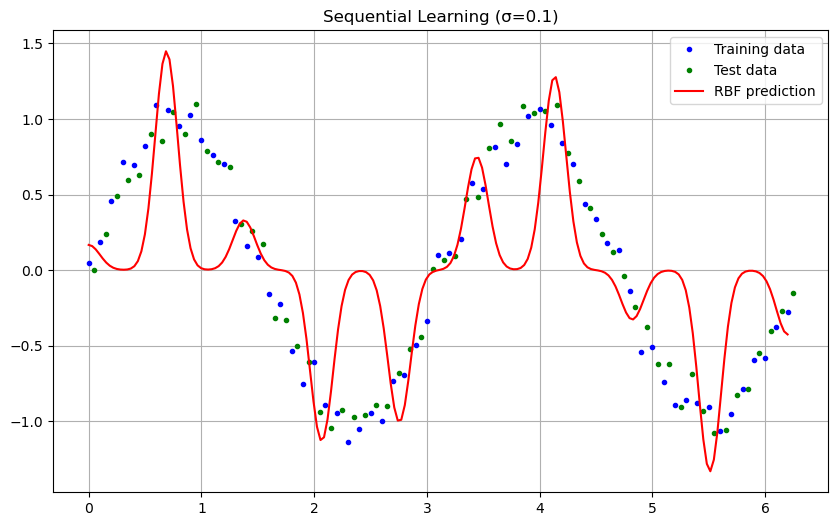

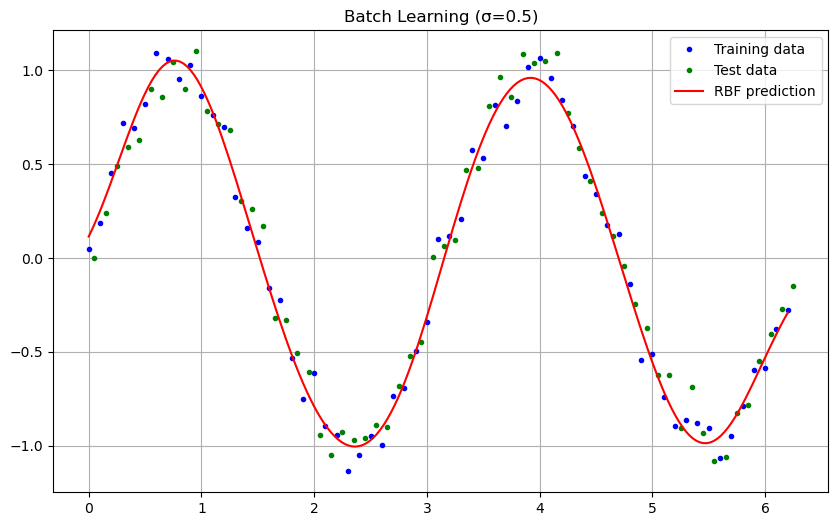

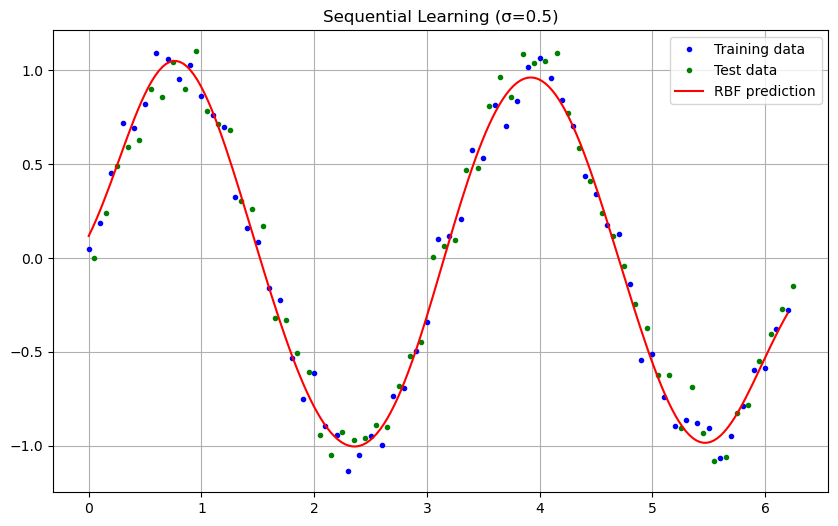

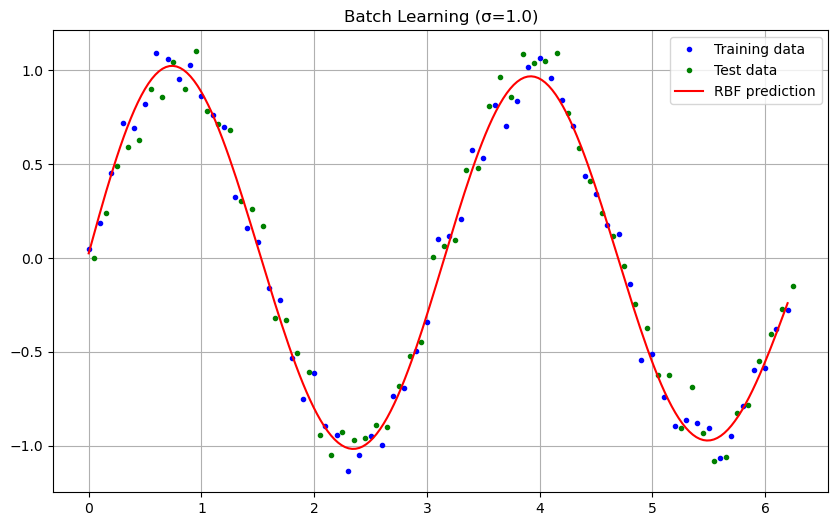

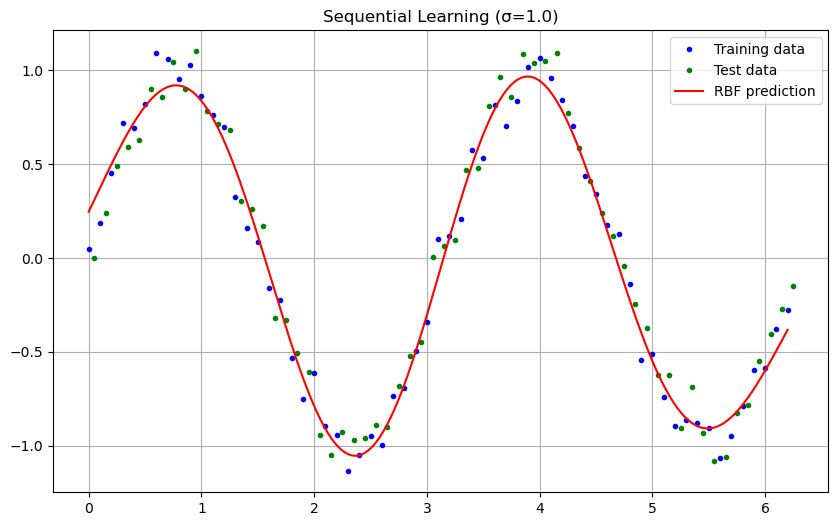

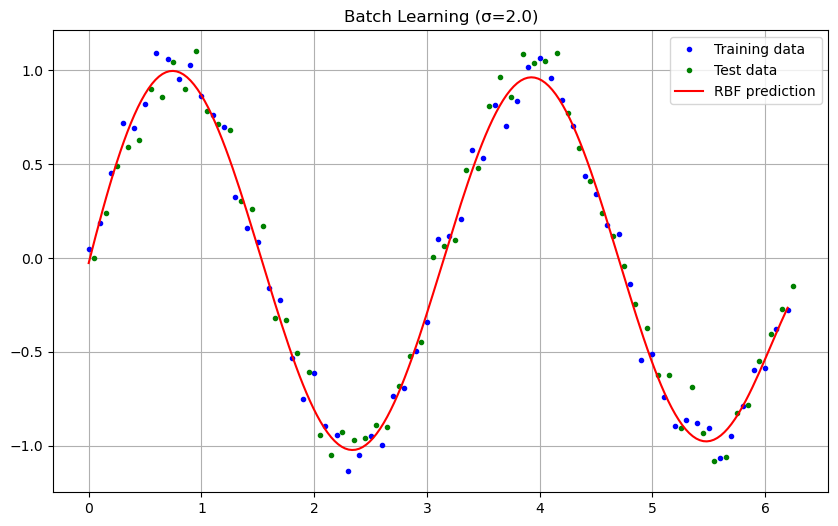

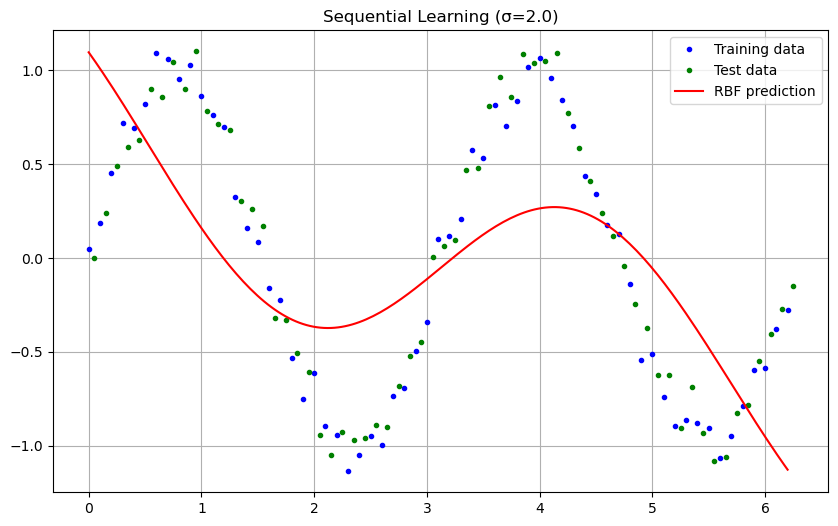

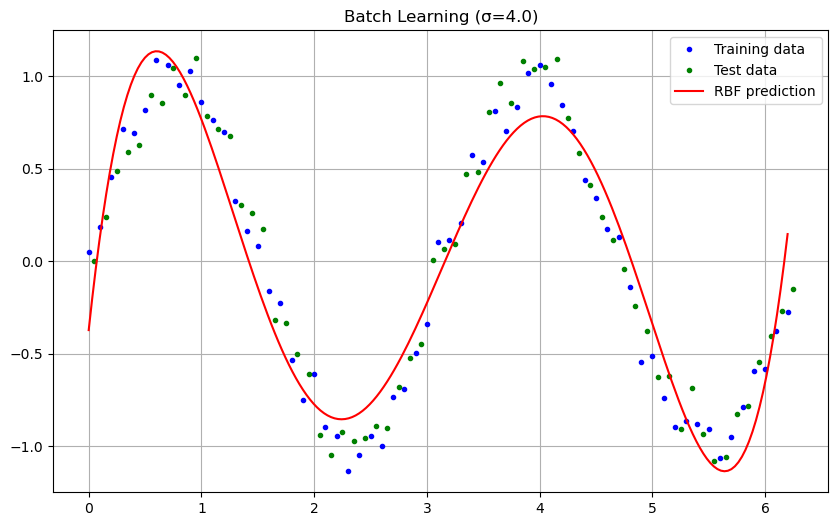

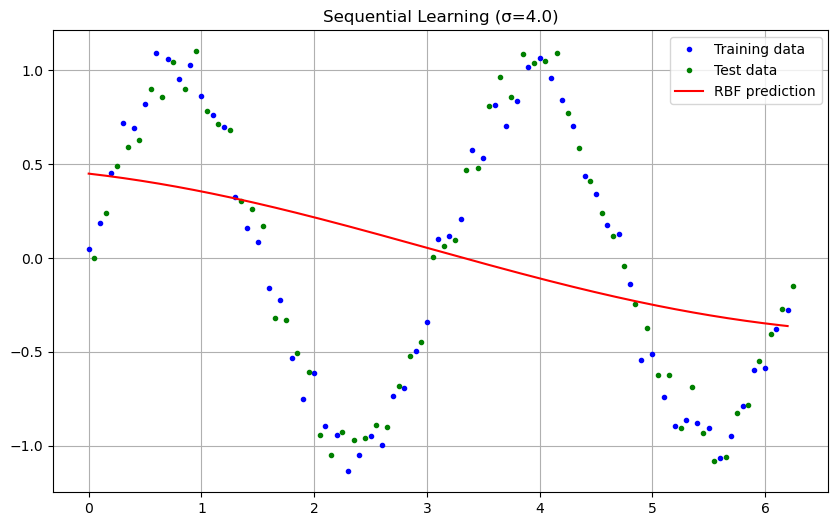

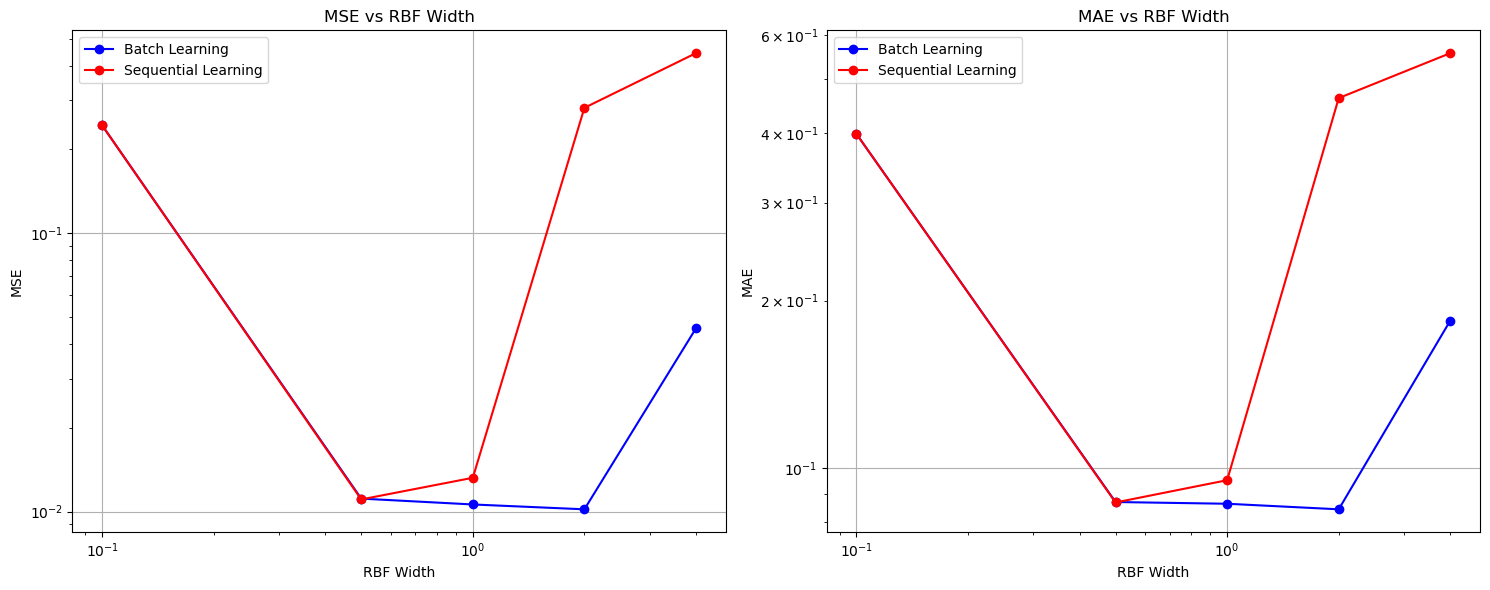

In [187]:
# Analyze width effects
width_analysis = analyze_rbf_width_effect(
    pattern, target1_noise, 
    pattern_test, target1_test_noise,
    n_units=10, 
    sigma_values=[0.1, 0.5, 1.0, 2.0, 4.0]
)

plot_width_analysis(width_analysis)

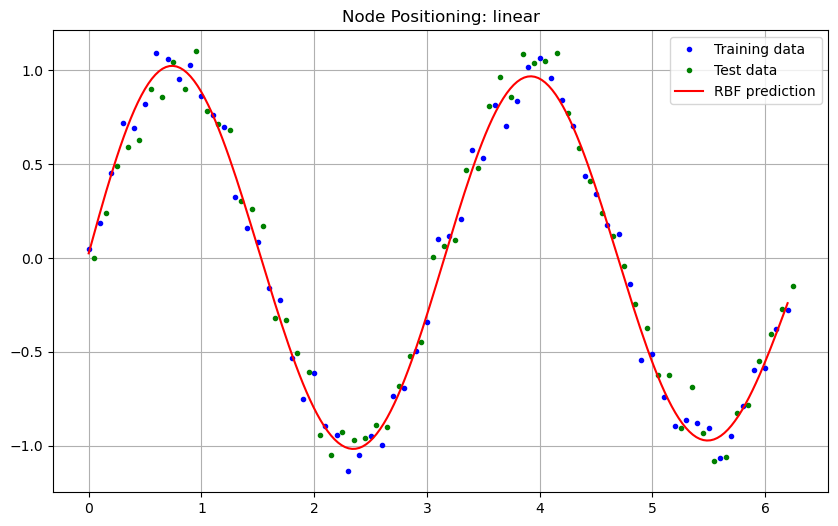

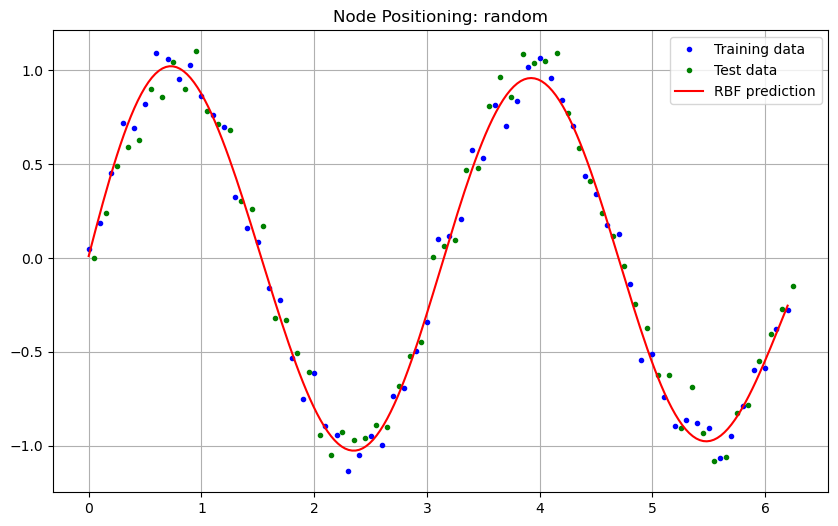

In [188]:
# Analyze node positioning
position_analysis = analyze_node_positioning(
    pattern, target1_noise,
    pattern_test, target1_test_noise,
    n_units=10, 
    sigma=1.0
)

In [189]:
# Compare on clean data
model_params = {
    'n_units': 10,
    'epochs': 1000,
    'lr': 0.01
}
clean_data_results = compare_on_clean_data(model_params, sigma_values=[0.1, 0.5, 1.0, 2.0, 4.0], noisy_trained=True)

In [190]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
error_mse_seq_lr = {}


for lr in learning_rates:
    mu = np.linspace(min(pattern), max(pattern), 10)
    w_seq, train_error_seq = sequential_learning(pattern, target1_noise, mu, sigma=1, epochs=10000, lr=lr)

    error_mse_seq_lr[lr] = train_error_seq

KeyboardInterrupt: 

In [ ]:
# Plot learning curves for different learning rates
plot_learning_error(error_mse_seq_lr, 'Learning Curves for Different Learning Rates', 'MSE error')